# Overview
In this Notebook, we are going to setup the framework for using a feature-based, [supervised learning](https://en.wikipedia.org/wiki/Supervised_learning) model to classify our gesture sets. While in the last assignment you built up familiarity with the SciPy libraries and an initial understanding of shape-based gesture classification, in this Notebook you will begin to learn:
- How to use [Scikit-learn](https://scikit-learn.org/), one of the most popular open-source machine learning libraries in the world
- How to rethink the classification problem not just in terms of signal **shapes** (as before) but in terms of signal **features**. You will brainstorm, visualize, and analyze both time-domain and frequency-domain features extracted from the gesture accelerometer data and learn how to find and then use potentially promising features in your classifier
- How to setup a classification experiment using Scikit-learn (you don't have to rely on your own k-fold cross validation code, for example)
- How to use some of the built-in supervised learning models in Scikit-learn to classify gestures

## Scikit learn

We are going to shift from using our own classifiers and experimental testbed (say goodbye to our custom `gesturerec.experiments` library) to a popular open-source machine learning library called [Scikit-learn](https://scikit-learn.org/stable/) ([code repo](https://github.com/scikit-learn/scikit-learn)). Scikit-learn (or sometimes called sklearn) started as a Google Summer of Code project and its name "SciKit" stems from using the [SciPy](https://www.scipy.org/) libraries as its foundation (though its development was and is independent).

We chose Scikit-learn as our primary machine learing library because:
- It is built on NumPy, SciPy, and matplotlib (so you need not learn another set of Python libraries)
- It is one of the most popular machine learning libraries in the world. On GitHub, for example, it has 25k+ commits and 40.8k stars ([link](https://github.com/scikit-learn/scikit-learn)). Building familiarity and comfort with Scikit-learn will not only increase your understanding of applied machine learning but also allow you to more easily use other machine learning toolkits in the future (*e.g.,* [PyTorch](https://pytorch.org/), [TensorFlow](https://www.tensorflow.org/)).

While this Notebook will cover some initial, core introductory concepts of using Scikit-learn—particularly for a gesture dataset—we are only scratching the surface of possibilities. You may want to consult the official [Scikit-learn tutorials](https://scikit-learn.org/stable/tutorial/index.html) either before or after working through this Notebook. Because of Scikit's popularity, there are also numerous (wonderful) tutorials online.

## Your TODOs

As before, you should use this Notebook as your template for the A4 assignment. We expect that you will read through and interact with cells sequentially. To help guide where you need to work, we've added "TODOs"—so search for that word. :)

# Imports

In [46]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt
import numpy as np 
import scipy as sp
from scipy import signal
import random
import os
import math
import itertools
from IPython.display import display_html

# Import Pandas
import pandas as pd

# We wrote this gesturerec package for the class
# It provides some useful data structures for the accelerometer signal
# and running experiments so you can focus on writing classification code, 
# evaluating your solutions, and iterating 
import gesturerec.utility as grutils
import gesturerec.data as grdata
import gesturerec.vis as grvis

from gesturerec.data import SensorData
from gesturerec.data import GestureSet

# Utility functions

In [47]:
def display_tables_side_by_side(df1, df2, n = None, df1_caption = "Caption table 1", df2_caption = "Caption table 2"):
    '''Displays the two tables side-by-side'''
    
    if n is not None:
        df1 = df1.head(n)
        df2 = df2.head(n)
    
    # Solution from https://stackoverflow.com/a/50899244
    df1_styler = df1.style.set_table_attributes("style='display:inline; margin:10px'").set_caption(df1_caption)
    df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption(df2_caption)

    display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)
    
def print_folds(cross_validator, X, y_true, trial_indices):
    '''Prints out the k-fold splits'''
    fold_cnt = 0
    for train_index, test_index in cross_validator.split(X, y_true):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_true.iloc[train_index], y_true.iloc[test_index]
        print("TEST FOLD {}".format(fold_cnt))
        for i in test_index:
            print("\t{} {}".format(y_true[i], trial_indices[i]))
        fold_cnt += 1
        
def display_folds(cross_validator, X, y_true, trial_indices):
    map_fold_to_class_labels = dict()
    fold_cnt = 0
    for train_index, test_index in cross_validator.split(X, y_true):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_true.iloc[train_index], y_true.iloc[test_index]
        
        class_labels = []
        for i in test_index:
            class_labels.append(f"{y_true[i]} {trial_indices[i]}")
        
        map_fold_to_class_labels[f"Fold {fold_cnt}"] = class_labels
        fold_cnt += 1
    
    df = pd.DataFrame(map_fold_to_class_labels)
    display(df)


def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes)

def get_top_n_frequency_peaks(n, freqs, amplitudes, min_amplitude_threshold = None):
    ''' Finds the top N frequencies and returns a sorted list of tuples (freq, amplitudes) '''
    
    # Use SciPy signal.find_peaks to find the frequency peaks
    # JonTODO: in future, could add in support for min horizontal distance so we don't find peaks close together
    # SciPy's find_peaks supports this, so would be straightforward to implement
    fft_peaks_indices, fft_peaks_props = sp.signal.find_peaks(amplitudes, height = min_amplitude_threshold)
    
    freqs_at_peaks = freqs[fft_peaks_indices]
    amplitudes_at_peaks = amplitudes[fft_peaks_indices]
    
    if n < len(amplitudes_at_peaks):
        ind = np.argpartition(amplitudes_at_peaks, -n)[-n:] # from https://stackoverflow.com/a/23734295
        ind_sorted_by_coef = ind[np.argsort(-amplitudes_at_peaks[ind])] # reverse sort indices
    else:
        ind_sorted_by_coef = np.argsort(-amplitudes_at_peaks)

    return_list = list(zip(freqs_at_peaks[ind_sorted_by_coef], amplitudes_at_peaks[ind_sorted_by_coef]))
    return return_list

map_marker_to_desc = {
    ".":"point",
    ",":"pixel",
    "o":"circle",
    "v":"triangle_down",
    "^":"triangle_up",
    "<":"triangle_left",
    ">":"triangle_right",
    "1":"tri_down",
    "2":"tri_up",
    "3":"tri_left",
    "4":"tri_right",
    "8":"octagon",
    "s":"square",
    "p":"pentagon",
    "*":"star",
    "h":"hexagon1",
    "H":"hexagon2",
    "+":"plus",
    "D":"diamond",
    "d":"thin_diamond",
    "|":"vline",
    "_":"hline"
}


def plot_feature_1d(gesture_set, extract_feature_func, title = None, use_random_y_jitter = True,
                   xlim = None):
    '''
    Plots the extracted feature on a 1-dimensional plot. We use a random y-jitter 
    to make the values more noticeable
    
    Parameters:
    
    gesture_set: the GestureSet class
    extract_feature_func: a "pointer" to a function that accepts a trial.accel object and returns an extracted feature
    title: the graph title
    use_random_y_jitter: provides a random y jitter to make it easier to see values
    xlim: set the x range of the graph
    '''
    markers = list(map_marker_to_desc.keys())
    random.Random(3).shuffle(markers)
    marker = itertools.cycle(markers)
    plt.figure(figsize=(12, 3))
    for gesture_name in selected_gesture_set.get_gesture_names_sorted():
        trials = selected_gesture_set.map_gestures_to_trials[gesture_name]
        x = list(extract_feature_func(trial.accel) for trial in trials)
        y = None
        
        if use_random_y_jitter:
            y = np.random.rand(len(x))
        else:
            y = np.zeros(len(x))
        
        marker_sizes = [200] * len(x) # make the marker sizes larger
        plt.scatter(x, y, alpha=0.65, marker=next(marker), 
                    s = marker_sizes, label=gesture_name)
        
    plt.ylim((0,3))
    
    if xlim is not None:
        plt.xlim(xlim)
    
    if use_random_y_jitter:
        plt.ylabel("Ignore the y-axis")
        
    plt.legend(bbox_to_anchor=(1,1))   
    
    if title is None:
        title = f"1D plot of {extract_feature_func.__name__}"
    
    plt.title(title)
    plt.show()
    
def plot_feature_2d(gesture_set, extract_feature_func1, extract_feature_func2,
                    xlabel = "Feature 1", ylabel = "Feature 2",
                    title = None, xlim = None):
    '''
    Plots the two extracted features on a 2-dimensional plot. 
    
    Parameters:
    
    gesture_set: the GestureSet class
    extract_feature_func1: a "pointer" to a function that accepts a trial.accel object and returns an extracted feature
    title: the graph title
    extract_feature_func2: a "pointer" to a function that accepts a trial.accel object and returns an extracted feature
    title: the graph title
    xlim: set the x range of the graph
    '''
    markers = list(map_marker_to_desc.keys())
    random.Random(3).shuffle(markers)
    marker = itertools.cycle(markers)
    plt.figure(figsize=(12, 5))
    for gesture_name in selected_gesture_set.get_gesture_names_sorted():
        trials = selected_gesture_set.map_gestures_to_trials[gesture_name]
        x = list(extract_feature_func1(trial.accel) for trial in trials)
        y = list(extract_feature_func2(trial.accel) for trial in trials)

        
        marker_sizes = [200] * len(x) # make the marker sizes larger
        plt.scatter(x, y, alpha=0.65, marker=next(marker), 
                    s = marker_sizes, label=gesture_name)
        
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if xlim is not None:
        plt.xlim(xlim)
           
    plt.legend(bbox_to_anchor=(1,1))   
    
    plt.title(title)
    plt.show()

# Load the data
These cells are the same as for the [Shape Matching](https://makeabilitylab.github.io/physcomp/signals/gesturerec/shapebased/index.html) notebook. You should not need to edit them, only run them.

In [48]:
# Load the data
#root_gesture_log_path = './GestureLogsADXL335'
root_gesture_log_path = './GestureLogs'

print("Found the following gesture log sub-directories")
print(grutils.get_immediate_subdirectories(root_gesture_log_path))

gesture_log_paths = grutils.get_immediate_subdirectories(root_gesture_log_path)
map_gesture_sets = dict()
selected_gesture_set = None

for gesture_log_path in gesture_log_paths:
    path_to_gesture_log = os.path.join(root_gesture_log_path, gesture_log_path)
    print("Creating a GestureSet object for path '{}'".format(path_to_gesture_log))
    gesture_set = GestureSet(path_to_gesture_log)
    gesture_set.load()
    map_gesture_sets[gesture_set.name] = gesture_set

if selected_gesture_set is None:
    # Since we load multiple gesture sets and often want to just visualize and explore
    # one set, in particular, we set a selected_gesture_set variable here
    # Feel free to change this
    #selected_gesture_set = get_random_gesture_set(map_gesture_sets)
    selected_gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, "Alexandra")
    if selected_gesture_set is None:
        # if the selected gesture set is still None
        selected_gesture_set = grdata.get_random_gesture_set(map_gesture_sets);

print("The selected gesture set:", selected_gesture_set)



Found the following gesture log sub-directories
['NickGestures', 'NanGestures', 'StacyGestures', 'AnjaliGestures', 'Paf2Gestures', 'AGestures', 'WolfGestures', 'ThweidGestures', 'AlexandraGestures', 'JaeHGestures', 'DustinGestures', 'JonGestures', 'MattCGestures', 'MikaelGestures', 'AlexisGestures', 'ShaunGestures', 'SamuelRGestures', 'JustinGestures', 'JasonGestures', 'NeilGestures', 'JuliaBGestures', 'BryanGestures', 'ClayGestures', 'NooseGestures', 'EmmaGestures', 'BrettGestures']
Creating a GestureSet object for path './GestureLogs/NickGestures'
Found 55 csv files in ./GestureLogs/NickGestures
Found 11 gestures
Found 5 trials for 'Midair Counter-clockwise 'O''
Found 5 trials for 'Drinking Coffee'
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'At Rest'
Found 5 trials for 'Midair Clockwise 'O''
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Midair 'S''
Found 5 trials for 'Shake'
Found 5 tria

Found 5 trials for 'At Rest'
Found 5 trials for 'Midair Clockwise 'O''
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Custom'
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Underhand Bowling'
Found 5 trials for 'Midair 'S''
Found 5 trials for 'Shake'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Forehand Tennis'
Max trial length across all gesture is 'At Rest' Trial 3 with 889 sensor events.
Avg samples/sec across 55 sensor files: 91.2
Avg sample length across 55 sensor files: 3.5s

Creating a GestureSet object for path './GestureLogs/MattCGestures'
Found 55 csv files in ./GestureLogs/MattCGestures
Found 11 gestures
Found 5 trials for 'At Rest'
Found 5 trials for 'Midair 'S''
Found 5 trials for 'Midair Counter-clockwise 'O''
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Shake'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Midair Clockwise 'O''
Found 5 trials for 'Custom'
Found 5 trials for 'Underhand Bowling'
Found 5 trials for 'For

Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'At Rest'
Max trial length across all gesture is 'Star' Trial 3 with 170 sensor events.
Avg samples/sec across 55 sensor files: 33.8
Avg sample length across 55 sensor files: 2.6s

Creating a GestureSet object for path './GestureLogs/BrettGestures'
Found 55 csv files in ./GestureLogs/BrettGestures
Found 11 gestures
Found 5 trials for 'Midair Counter-clockwise 'O''
Found 5 trials for 'At Rest'
Found 5 trials for 'Midair 'S''
Found 5 trials for 'Shake'
Found 5 trials for 'Midair Clockwise 'O''
Found 5 trials for 'Custom'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Underhand Bowling'
Max trial length across all gesture is 'Underhand Bowling' Trial 3 with 452 sensor events.
Avg samples/sec across 55 sensor files: 91.2
Avg sample length across 55 sensor files: 3.4s

The selected gesture set: './GestureLogs/Alexand

The `map_gesture_sets` is a `dict` object and is our primary data structure: it maps gesture dir names to `GestureSet` objects. There's truly nothing special here. But we realize our data structures do require a learning ramp-up. Let's iterate through the GestureSets.

In [49]:
print(f"We have {len(map_gesture_sets)} gesture sets:")
for gesture_set_name, gesture_set in map_gesture_sets.items():
    print(f" {gesture_set_name} with {len(gesture_set.get_all_trials())} trials")

# Feel free to change the selected_gesture_set. It's just a convenient variable
# to explore one gesture set at a time
print(f"The selected gesture set is: {selected_gesture_set.name}")

We have 26 gesture sets:
 NickGestures with 55 trials
 NanGestures with 55 trials
 StacyGestures with 55 trials
 AnjaliGestures with 55 trials
 Paf2Gestures with 55 trials
 AGestures with 55 trials
 WolfGestures with 55 trials
 ThweidGestures with 55 trials
 AlexandraGestures with 55 trials
 JaeHGestures with 55 trials
 DustinGestures with 55 trials
 JonGestures with 55 trials
 MattCGestures with 55 trials
 MikaelGestures with 55 trials
 AlexisGestures with 55 trials
 ShaunGestures with 55 trials
 SamuelRGestures with 55 trials
 JustinGestures with 55 trials
 JasonGestures with 55 trials
 NeilGestures with 55 trials
 JuliaBGestures with 55 trials
 BryanGestures with 55 trials
 ClayGestures with 55 trials
 NooseGestures with 55 trials
 EmmaGestures with 55 trials
 BrettGestures with 55 trials
The selected gesture set is: AlexandraGestures


# Preprocess the data

You may or may not want to revisit how you preprocess your data. Remember: we are using a fundamentally different approach for classification, so it's worth reconsidering your full data analysis pipeline.

In [50]:
def preprocess_signal(s):
    '''Preprocesses the signal'''
    
    # TODO: write your preprocessing code here. We'll do something very simple for now,
    
    mean_filter_window_size = 10
    processed_signal = np.convolve(s, 
                                   np.ones((mean_filter_window_size,))/mean_filter_window_size, 
                                   mode='valid')
    return processed_signal

def preprocess_trial(trial):
    '''Processess the given trial'''
    trial.accel.x_p = preprocess_signal(trial.accel.x)
    trial.accel.y_p = preprocess_signal(trial.accel.y)
    trial.accel.z_p = preprocess_signal(trial.accel.z)
    trial.accel.mag_p = preprocess_signal(trial.accel.mag)

for gesture_set in map_gesture_sets.values():
    for gesture_name, trials in gesture_set.map_gestures_to_trials.items():
        for trial in trials:
            preprocess_trial(trial)

# Feature exploration

We are going to start this adventure, as we always should, by trying to better understand our signals and the features we plan to extract.

Our goal is to brainstorm and identify highly discriminable attributes of each gesture class that we may be able to leverage in our feature-based classifiers.

While our classifiers will work in high-dimensions, humans, at best can really only visualize and interpret at most 3-dimensions.

So, we're going to start by graphing our features along 1-dimension. Yes, 1-dimension! To make it easier to see patterns in our data, we will add in a bit of y-jitter, so the graphs below may appear 2-dimensional—but they are not. Ignore the y-axis for these 1D plots.

## Time domain

Let's explore some time domain features first. We've created a helper function called `plot_feature_1d`, which will plot a specified feature in a 1-dimensional graph.

Let's check it out!

### Feature: standard deviation of accel mag

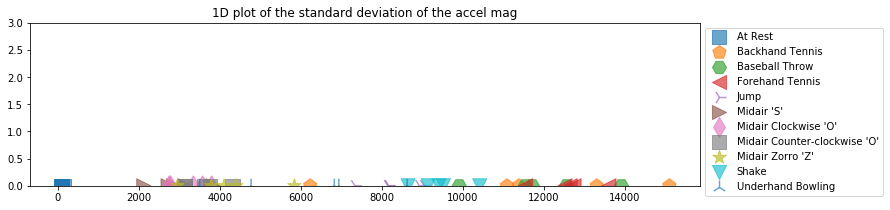

In [51]:
# Write a simple anonymous function that takes in an accel.trial and returns
# an extracted feature. In this case, the standard deviation of the magnitude
extract_feature_std_mag = lambda accel_trial: np.std(accel_trial.mag)

# We could also have done the following but it's slightly messier for our purposes
# def extract_feature_std_mag(accel_trial):
#    return np.std(accel_trial.mag)

# Plot the feature (but with no y-jitter)
graph_title = "1D plot of the standard deviation of the accel mag"
plot_feature_1d(selected_gesture_set, extract_feature_std_mag, 
                title = graph_title, use_random_y_jitter = False)

To make it easier to see the 1-dimensional spacing, by default, we add in a random y-jitter (which is a common graphing trick). But just remember, the y-values here are meaningless.

So, let's graph the same thing but with the random y jitter turned on.

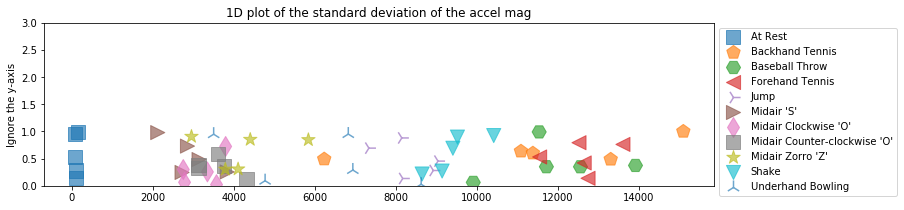

In [52]:
graph_title = "1D plot of the standard deviation of the accel mag"
plot_feature_1d(selected_gesture_set, extract_feature_std_mag, title = graph_title)

Even with just one feature and a 1D plot, we can begin to see some separation between gestures:
- Unsurprisingly, the *At Rest* gesture has the least amount of deviation
- And then there are ~2 or maybe 3 other groups: a middle group of *Clockwise 'O'*, *Counter-clockwise 'O'*, *Backhand Tennis*, a less defined intermediate group of *Forehand Tennis* and *Underhand Bowling*, and a more extreme group of *Shake*, *Midair Zorro 'Z'*, and *Baseball Throw*
    

### Feature: maximum accel mag

How about the **maximum** of the accelerometer magnitude in each gesture trial? Is there discriminable information there?

Let's check it out!

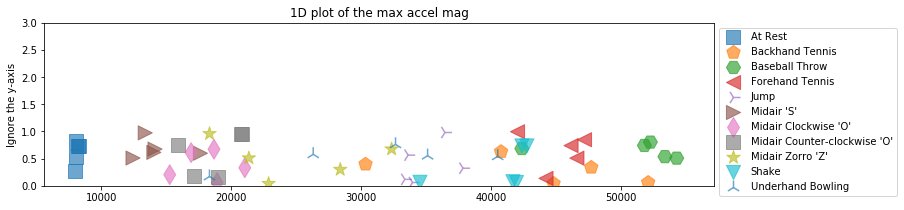

In [53]:
extract_feature_max_mag = lambda accel_trial: np.max(accel_trial.mag)
plot_feature_1d(selected_gesture_set, extract_feature_max_mag, 
                title = "1D plot of the max accel mag")

What do you observe? Again, this feature seems useful—at least for discriminating some gestures like *At Rest* and *Baseball Throw*. As before, there are also clear clusters that are emerging.

### Brainstorm and plot your own time domain features

Below, brainstorm and plot your own time domain features. We've provided an initial list of features to try but dig into the signals, think about what makes each gesture class unique, and try to extract and leverage those unique aspects as features. 

You could extract (many of) these features either from the raw accelerometer signal (*e.g.,* `x`, `y`, `z`, and `mag`) or a preprocessed version.

- Signal length
- Descriptive statistics of each axis (x, y, z) + magnitude, including mean, median, standard deviation
- Peak counting (raw number of peaks, number of peaks over certain threshold)
- Horizontal distance between peaks, avg vertical distance between peaks
- Number of zero crossings
- Other things! Read papers, brainstorm, visualize!

Once you've exhausted our list and your own mind, consult the web. Use [Google Scholar](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C48&q=gesture+recognition+accelerometer&btnG=), for example, to find gesture recognition papers: what features did they use?

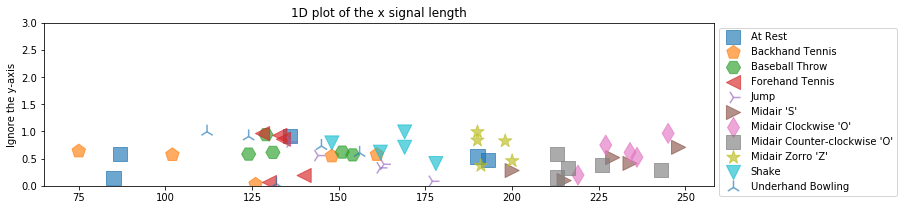

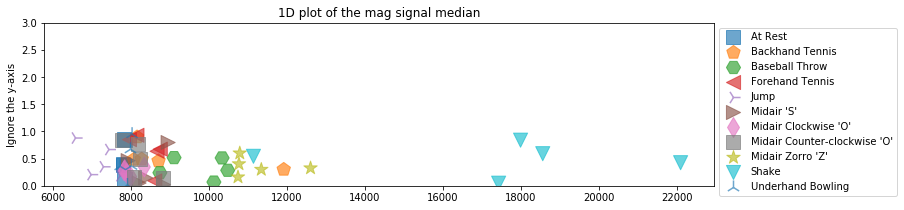

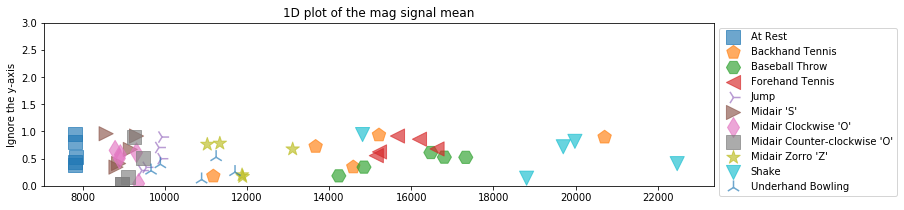

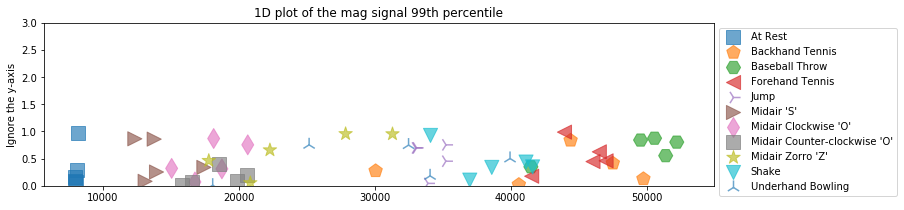

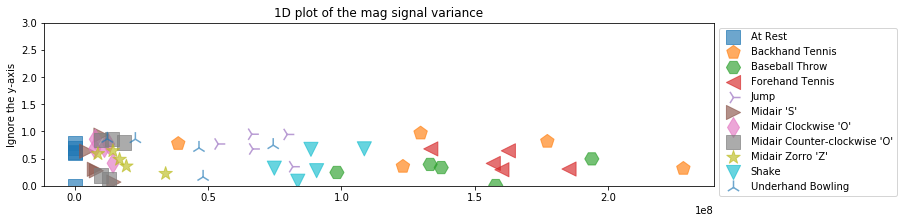

In [54]:
# We'll start with another one here: signal length but add more!

extract_feature_signal_length = lambda accel_trial: len(accel_trial.x)
plot_feature_1d(selected_gesture_set, extract_feature_signal_length, 
                title = "1D plot of the x signal length")

# First: The median of the mag signal
extract_feature_mag_median = lambda accel_trial: np.median(accel_trial.mag)
plot_feature_1d(selected_gesture_set, extract_feature_mag_median, 
                title = "1D plot of the mag signal median")

# Second: The mean of the mag signal
extract_feature_mag_mean = lambda accel_trial: np.mean(accel_trial.mag)
plot_feature_1d(selected_gesture_set, extract_feature_mag_mean, 
                title = "1D plot of the mag signal mean")

# Third: The 99th percentile of the mag signal
extract_feature_mag_99 = lambda accel_trial: np.percentile(accel_trial.mag, 99)
plot_feature_1d(selected_gesture_set, extract_feature_mag_99, 
                title = "1D plot of the mag signal 99th percentile")

# Fourth: The variance of the mag signal
extract_feature_mag_variance = lambda accel_trial: np.nanvar(accel_trial.mag)
plot_feature_1d(selected_gesture_set, extract_feature_mag_variance, 
                title = "1D plot of the mag signal variance")

## Frequency domain

Of course, there may also be discriminable information in the frequency domain. If you haven't already, complete our [Frequency Analysis](https://makeabilitylab.github.io/physcomp/signals/FrequencyAnalysis/index.html) lesson before moving forward.

Just as we brainstormed time domain features, how about features in the frequency domain, such as:
- The top frequency (*i.e.,* the frequency with the highest amplitude in the signal)
- The top N frequencies (overall or within some frequency band)
- The lowest/highest frequency (over some amplitude threshold)
- Number of frequency peaks (over a certain amplitude threshold)
- Avg value of frequency peaks
- Or perhaps a sliding window that breaks up the signal into chunks and extracts frequency information over each chunk
- And many others...

### Visualizing frequency information 

Let's start—as we always should—by plotting our signals and exploring some initial stats.

Below, we plot a visualization grid where each column is a gesture trial and rows alternate between the time domain and frequency domain versions of the `mag` for that gesture.

IntProgress(value=0, max=22)

Selected gesture set: AlexandraGestures


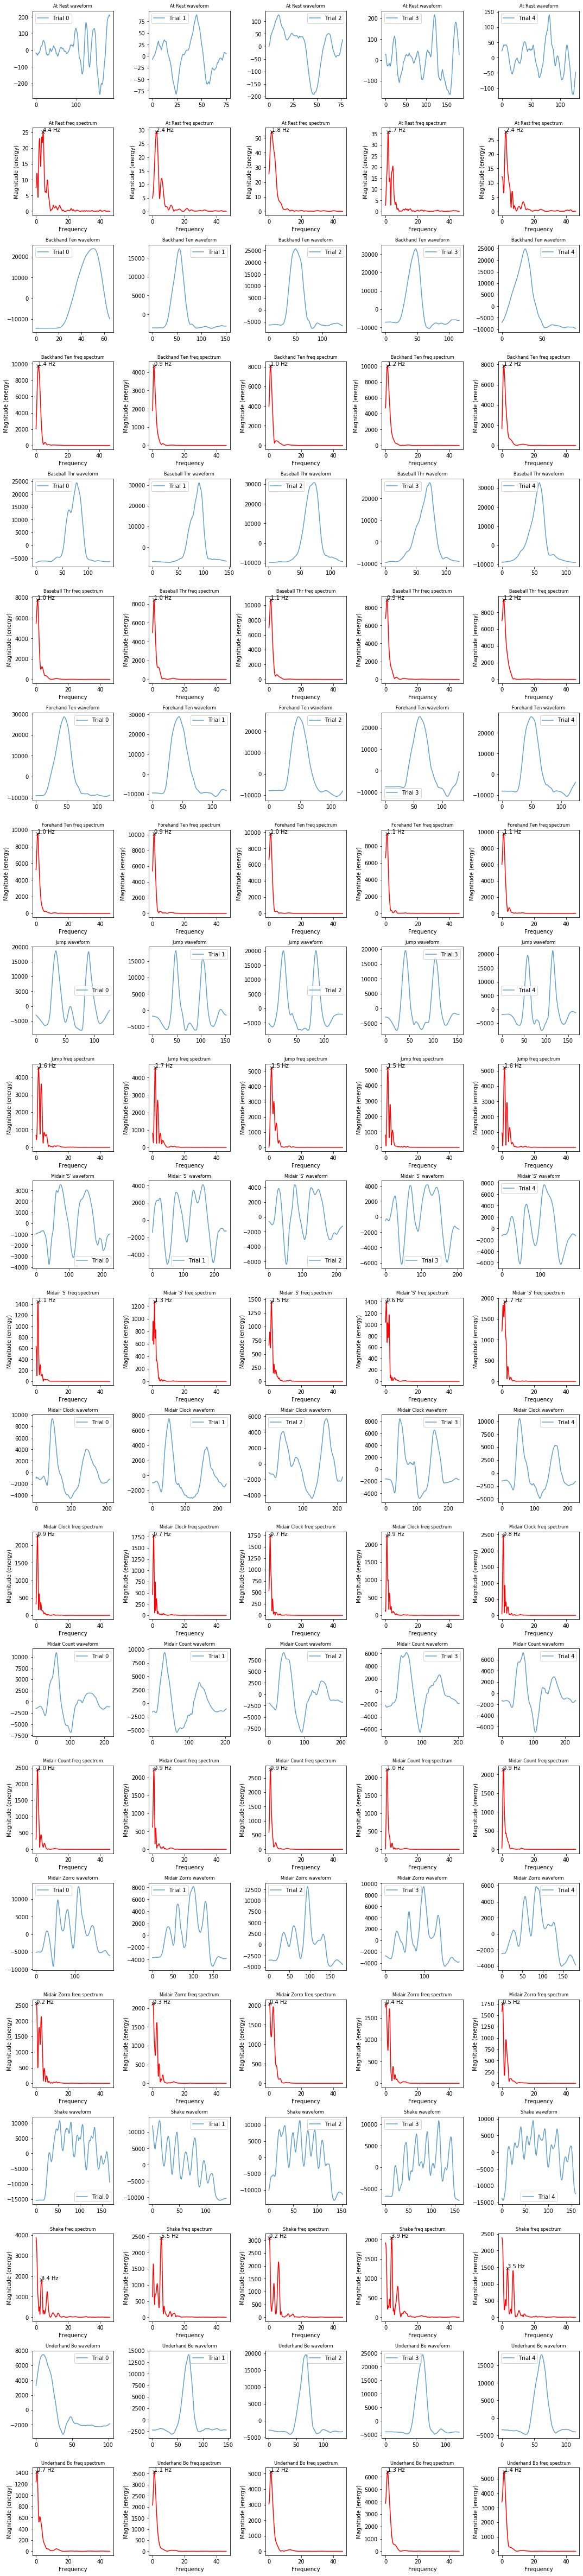

In [55]:
# This cell will take a bit of time not because of the frequency analysis but because
# of preparing the large matplotlib image
import IPython.display as ipd
import ipywidgets

num_cols = 5 # 1 col for each gesture trial 
num_rows = selected_gesture_set.get_num_gestures() * 2 # 1 for waveform, 1 for frequency per gesture
row_height = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, row_height * num_rows))

index = 0
sampling_rate = 92 # roughly 92
progress_bar = ipywidgets.IntProgress(value=0, min=0, max=num_rows)
ipd.display(progress_bar)
title_font_size = 8
for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    gesture_trials = selected_gesture_set.get_trials_for_gesture(gesture_name)
    
    for trial in gesture_trials:
        s = trial.accel.mag_p # change this to visualize/explore other signals
        ax = axes[index][trial.trial_num]
        
        # remove "DC offset" to perform FFT
        s_removed_offset = s - np.mean(s)
        
        ax.plot(s_removed_offset, alpha=0.7, label=f"Trial {trial.trial_num}")
        ax.set_title(f"{gesture_name[0:12]} waveform", fontsize= title_font_size)
        ax.legend()
        
        sampling_rate = math.ceil(trial.accel.sampling_rate)
        ax = axes[index + 1][trial.trial_num]
        spectrum, freqs_of_spectrum, line = ax.magnitude_spectrum(s_removed_offset, Fs = sampling_rate, 
                                                        color='r', pad_to = 4 * len(s))
        ax.set_title(f"{gesture_name[0:12]} freq spectrum", fontsize= title_font_size)
        
        # Annotate the top freq (by amplitude) on each graph
        top_n_freq_with_amplitudes = get_top_n_frequency_peaks(1, freqs_of_spectrum, spectrum)
        top_freq = top_n_freq_with_amplitudes[0][0]
        top_amplitude = top_n_freq_with_amplitudes[0][1]
        ax.plot(top_freq, top_amplitude, marker="x", color="black", alpha=0.8)
        ax.text(top_freq, top_amplitude, f"{top_freq:0.1f} Hz", color="black")
      
    index = index + 2 
    progress_bar.value = index
    
fig.tight_layout(pad=1)

print(f"Selected gesture set: {selected_gesture_set.name}")

### Feature: top frequency
As one example, let's extract the most prominent (highest-amplitude) frequency for each gesture using the magnitude part of the accelerometer signal.

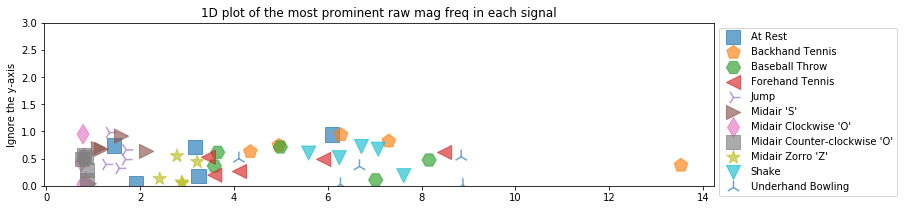

In [56]:
def extract_feature_top_mag_freq(accel_trial):
    sampling_rate = math.ceil(accel_trial.sampling_rate)
    (fft_freqs, fft_amplitudes) = compute_fft(accel_trial.mag, sampling_rate)
    top_n_freq_with_amplitudes = get_top_n_frequency_peaks(1, fft_freqs, fft_amplitudes)

    if len(top_n_freq_with_amplitudes) <= 0:
        return 0
    
    return top_n_freq_with_amplitudes[0][0]

plot_feature_1d(selected_gesture_set, extract_feature_top_mag_freq, 
                title = "1D plot of the most prominent raw mag freq in each signal")

You might be surprised to see *At Rest's* position in the graph. This is because we do not take into account the *strength* of the frequency component for each signal. The identified frequencies in *At Rest* are low amplitude (and largely noise).

To control for this, we can add in a parameter to `get_top_n_frequency_peaks` to filter out identified frequencies of less than a certain amplitude coefficient. In this case, let's try `500` but you should experiment with any thresholds used in your code.

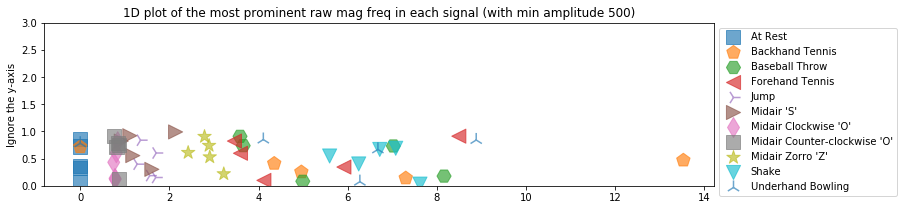

In [57]:
def extract_feature_top_mag_freq2(accel_trial):
    sampling_rate = math.ceil(accel_trial.sampling_rate)
    (fft_freqs, fft_amplitudes) = compute_fft(accel_trial.mag, sampling_rate)
    top_n_freq_with_amplitudes = get_top_n_frequency_peaks(1, fft_freqs, fft_amplitudes, min_amplitude_threshold = 500)

    if len(top_n_freq_with_amplitudes) <= 0:
        return 0
    
    return top_n_freq_with_amplitudes[0][0]

plot_feature_1d(selected_gesture_set, extract_feature_top_mag_freq2, 
                title = "1D plot of the most prominent raw mag freq in each signal (with min amplitude 500)")

We are able to see roughly four groupings here:
- The *At Rest* group
- A second cluster with frequencies between ~0.5 and 2.5 Hz
- Possibly a third cluster with *Zorro* and *Forehand Tennis* between ~2.5 and 5 Hz
- And another clear outlier cluster for *Shake* with freq between ~5-15 Hz

Let's zoom into the x-axis a bit to explore the middle cluster more closely.

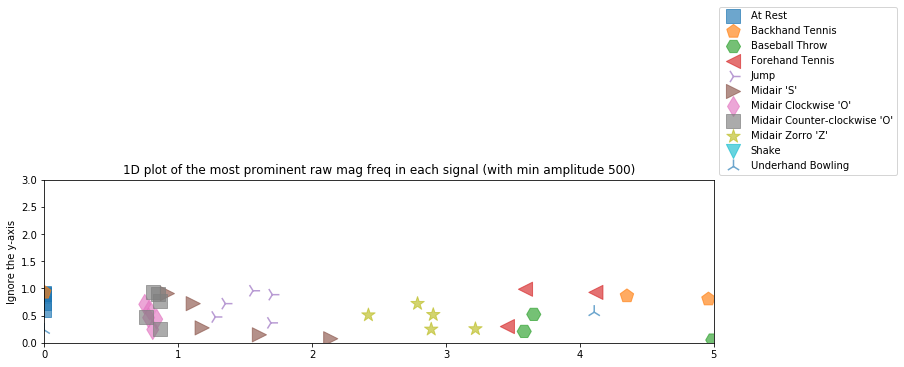

In [58]:
plot_feature_1d(selected_gesture_set, extract_feature_top_mag_freq2, 
                title = "1D plot of the most prominent raw mag freq in each signal (with min amplitude 500)",
                xlim = (0, 5))

We can, of course, perform frequency analyses on any other signal—be it `x`, `y`, `z`, `mag` or some processed version. For example, here's a frequency analysis of a preprocessed `mag_p` signal.

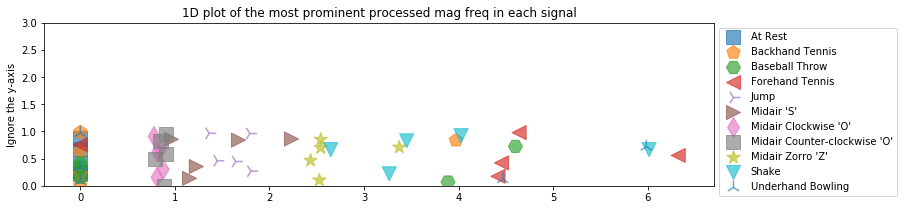

In [59]:
def extract_feature_top_mag_p_freq(accel_trial):
    sampling_rate = math.ceil(accel_trial.sampling_rate)
    (fft_freqs, fft_amplitudes) = compute_fft(accel_trial.mag_p, sampling_rate)
    top_n_freq_with_amplitudes = get_top_n_frequency_peaks(1, fft_freqs, fft_amplitudes, min_amplitude_threshold = 500)

    if len(top_n_freq_with_amplitudes) <= 0:
        return 0
    
    return top_n_freq_with_amplitudes[0][0]

plot_feature_1d(selected_gesture_set, extract_feature_top_mag_p_freq, 
                title = "1D plot of the most prominent processed mag freq in each signal")

### Brainstorm and plot your own frequency domain features

What other features can you think of for the frequency domain?

In [60]:
# TODO: Graph additional frequency-based features, i.e:
# The top N frequencies (overall or within some frequency band)
# The lowest/highest frequency (over some amplitude threshold)
# Number of frequency peaks (over a certain amplitude threshold)
# Avg value of frequency peaks
# Or perhaps a sliding window that breaks up the signal into chunks and extracts frequency information over each chunk
# TODO: !!!! You left off here!

## 2-dimensional explorations

OK, now that we've built up some familiarity with feature extraction and how these features may enable us to discriminate gestures, let's plot various combinations of them in 2D. Again, remember that our classifiers will (often) work in N-dimensions where N is the number of features. But it's just not possible for us to visualize all of our features at once in an N-dimensional graph.

But at least we're going from 1D to 2D, wee! :)

We'll begin by just randomly choosing some features to plot together: how about the standard deviation of the accel `mag` and the max `mag`?

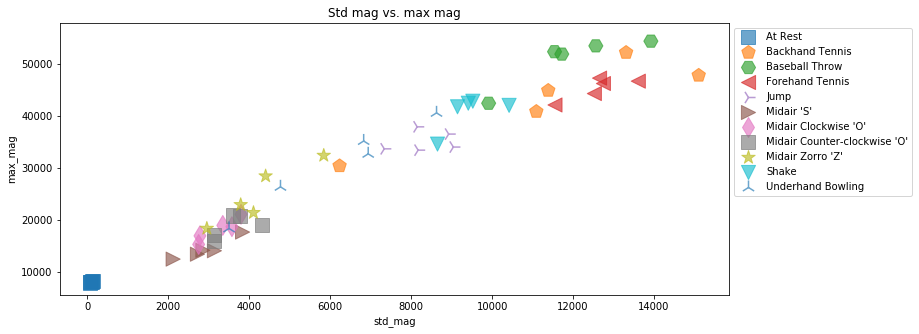

In [61]:
plot_feature_2d(selected_gesture_set, extract_feature_std_mag, extract_feature_max_mag,
               xlabel="std_mag", ylabel="max_mag", title="Std mag vs. max mag")

Again, our goal here is to see clear clusters emerging—ideally where each cluster is composed of the same gesture class and the clusters themselves have clear separation.

Let's try another combination. How about the max `mag` frequency component (in frequency domain) and the max `mag` signal value (in the time domain).

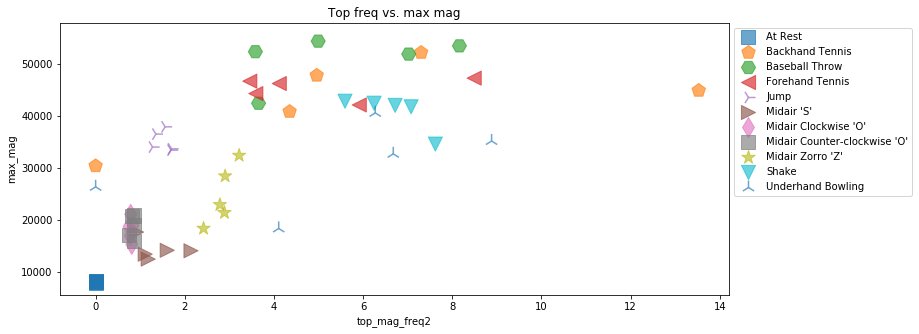

In [62]:
# plot_feature_2d(selected_gesture_set, extract_feature_top_mag_freq2, extract_feature_std_mag,
#                xlabel="extract_feature_top_mag_freq2", ylabel="max_mag", title="Std mag vs. max mag")

plot_feature_2d(selected_gesture_set, extract_feature_top_mag_freq2, extract_feature_max_mag,
               xlabel="top_mag_freq2", ylabel="max_mag", title="Top freq vs. max mag")

Again, now it's up to you. Try graphing some feature combinations below.

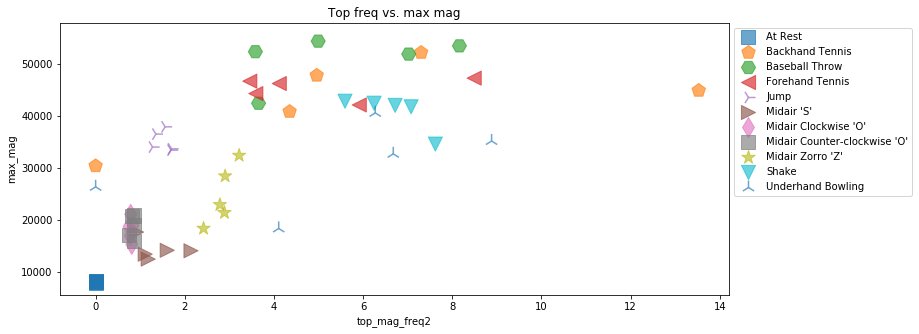

In [63]:
# TODO: Write some of your own 2D plot explorations

#First
plot_feature_2d(selected_gesture_set, extract_feature_top_mag_freq2, extract_feature_max_mag,
               xlabel="top_mag_freq2", ylabel="max_mag", title="Top freq vs. max mag")

## Pandas

At risk of introducing too many frameworks and libraries in this course (I know!), we had to bring in one more: [pandas](https://pandas.pydata.org/)—one of the most popular open-source data analysis tools in data science. And pandas builds on and uses SciPy libraries.

Rest assured, we are *barely* going to use pandas. But we are going to use pandas [DataFrame](https://pandas.pydata.org/docs/getting_started/dsintro.html#dataframe) data structures, which are 2-dimensional tables a bit like a spreadsheet or an SQL table. They support querying, filtering, *etc.* but we mainly use them because it makes interacting with Scikit-learn easier (in our humble opinions, at least).

And again, don't worry. We show you everything you need to know below. You can certainly dive deeper, if you want. Knowing pandas gives you major data science street cred. :) 

While not necessary, you may want to check out the official [10-minute pandas tutorial](https://pandas.pydata.org/docs/getting_started/dsintro.html) or just dive in below.

### Create pandas DataFrame of features
Below, we build a pandas DataFrame table of our features. This is just a small playground. The *real* feature extraction code that we use in our classification experiments is found below in the sub-section entitled [Feature extraction code](#Feature-extraction-code).

In [64]:
df = None
for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    trials = selected_gesture_set.map_gestures_to_trials[gesture_name]
    
    for trial in trials:
        features = dict()
        features["gesture_set"] = selected_gesture_set.name
        features["gesture"] = gesture_name
        features["trial_num"] = trial.trial_num
        features["signal_length (samples)"] = extract_feature_signal_length(trial.accel)
        features["signal_length (secs)"] = trial.accel.length_in_secs
        features["max_mag"] = extract_feature_max_mag(trial.accel)
        features["max_mag_p"] = np.max(trial.accel.mag_p)
        features["std_mag"] = extract_feature_std_mag(trial.accel)
        features["top_mag_freq"] = extract_feature_top_mag_freq2(trial.accel)
        features["mag_mean"] =  extract_feature_mag_mean(trial.accel)
        features["mag_median"] =  extract_feature_mag_median(trial.accel)
        features["mag_99"] =  extract_feature_mag_99(trial.accel)
        features["mag_variance"] =  extract_feature_mag_variance(trial.accel)
        
        if df is None:
            df = pd.DataFrame([features])
        else:
            df = df.append(features, ignore_index=True)

# Calling display on a DataFrame creates a pretty HTML-formatted table!
# Print out only the first 11 rows
display(df.head(n = 11))


,gesture_set,gesture,trial_num,signal_length (samples),signal_length (secs),max_mag,max_mag_p,std_mag,top_mag_freq,mag_mean,mag_median,mag_99,mag_variance
0,AlexandraGestures,At Rest,0,193,2.115,8300.053012,8043.954520,139.053281,0.000000,7833.820350,7832.567906,8201.584403,1.933582e+04
1,AlexandraGestures,At Rest,1,85,0.925,7940.434245,7900.072219,65.610007,0.000000,7808.974812,7805.917755,7938.578895,4.304673e+03
2,AlexandraGestures,At Rest,2,87,0.947,8033.736864,7943.525673,102.611822,0.000000,7818.922965,7833.613725,7991.790366,1.052919e+04
3,AlexandraGestures,At Rest,3,190,2.079,8169.860709,8029.516410,107.593451,0.000000,7812.350313,7802.498060,8084.792081,1.157635e+04
4,AlexandraGestures,At Rest,4,136,1.485,8032.637425,7947.785824,79.113038,0.000000,7807.774945,7810.778185,8025.054029,6.258873e+03
5,AlexandraGestures,Backhand Tennis,0,75,0.813,47741.817644,46141.660607,15105.128947,4.960000,20708.355931,11917.282912,47512.292482,2.281649e+08
6,AlexandraGestures,Backhand Tennis,1,161,1.761,30352.603051,28808.761101,6231.938713,0.000000,11184.139482,8155.590966,30070.805362,3.883706e+07
7,AlexandraGestures,Backhand Tennis,2,148,1.616,40794.107810,39801.711672,11093.187484,4.351351,13674.556546,8070.720420,40604.046265,1.230588e+08
8,AlexandraGestures,Backhand Tennis,3,126,1.375,52131.314812,48024.406070,13310.866005,7.301587,14590.932169,8273.476083,49763.040050,1.771792e+08
9,AlexandraGestures,Backhand Tennis,4,102,1.112,44840.470292,40954.859102,11387.566961,13.529412,15216.003159,8706.669276,44408.214111,1.296767e+08


### Pandas groupby
Similar to SQL, you can create groupings using the [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) function and then use [describe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html) to generate descriptive stats for each gesture (applied across all trials).

In [65]:
display(df.groupby('gesture').describe())

trial_num                                     \
                                 count mean       std  min  25%  50%  75%   
gesture                                                                     
At Rest                            5.0  2.0  1.581139  0.0  1.0  2.0  3.0   
Backhand Tennis                    5.0  2.0  1.581139  0.0  1.0  2.0  3.0   
Baseball Throw                     5.0  2.0  1.581139  0.0  1.0  2.0  3.0   
Forehand Tennis                    5.0  2.0  1.581139  0.0  1.0  2.0  3.0   
Jump                               5.0  2.0  1.581139  0.0  1.0  2.0  3.0   
Midair 'S'                         5.0  2.0  1.581139  0.0  1.0  2.0  3.0   
Midair Clockwise 'O'               5.0  2.0  1.581139  0.0  1.0  2.0  3.0   
Midair Counter-clockwise 'O'       5.0  2.0  1.581139  0.0  1.0  2.0  3.0   
Midair Zorro 'Z'                   5.0  2.0  1.581139  0.0  1.0  2.0  3.0   
Shake                              5.0  2.0  1.581139  0.0  1.0  2.0  3.0   
Underhand Bowling                  5.0  2.0  1.581139  0.0  1.0  2.0  3.0   

                                  signal_length (samples)         ...  \
                              max                   count   mean  ...   
gesture                                                           ...   
At Rest                       4.0                     5.0  138.2  ...   
Backhand Tennis               4.0                     5.0  122.4  ...   
Baseball Throw                4.0                     5.0  137.8  ...   
Forehand Tennis               4.0                     5.0  133.0  ...   
Jump                          4.0                     5.0  156.4  ...   
Midair 'S'                    4.0                     5.0  225.2  ...   
Midair Clockwise 'O'          4.0                     5.0  232.2  ...   
Midair Counter-clockwise 'O'  4.0                     5.0  222.2  ...   
Midair Zorro 'Z'              4.0                     5.0  193.8  ...   
Shake                         4.0                     5.0  165.2  ...   
Underhand Bowling             4.0                     5.0  133.8  ...   

                                    mag_99               mag_variance  \
                                       75%           max        count   
gesture                                                                 
At Rest                        8084.792081   8201.584403          5.0   
Backhand Tennis               47512.292482  49763.040050          5.0   
Baseball Throw                51399.882120  52214.431773          5.0   
Forehand Tennis               46519.043024  47016.296683          5.0   
Jump                          35238.148411  35244.503190          5.0   
Midair 'S'                    13960.455479  17442.740859          5.0   
Midair Clockwise 'O'          18767.705464  20668.221740          5.0   
Midair Counter-clockwise 'O'  19894.338647  20615.899076          5.0   
Midair Zorro 'Z'              27864.035532  31310.926954          5.0   
Shake                         41131.929107  41614.056672          5.0   
Underhand Bowling             34075.878207  39954.952935          5.0   

                                                                        \
                                      mean           std           min   
gesture                                                                  
At Rest                       1.040098e+04  5.821323e+03  4.304673e+03   
Backhand Tennis               1.393833e+08  7.032239e+07  3.883706e+07   
Baseball Throw                1.441320e+08  3.508601e+07  9.830740e+07   
Forehand Tennis               1.596837e+08  1.842854e+07  1.334928e+08   
Jump                          6.969829e+07  1.137320e+07  5.381785e+07   
Midair 'S'                    8.921020e+06  3.771897e+06  4.492771e+06   
Midair Clockwise 'O'          1.073358e+07  3.037250e+06  7.562133e+06   
Midair Counter-clockwise 'O'  1.305828e+07  3.659136e+06  9.765215e+06   
Midair Zorro 'Z'              1.868702e+07  9.488763e+06  8.715839e+06   
Shake           

### Pairwise correlation

We can use Pandas to calculate a pairwise correlation between features. Often, we want features that have low (near zero) correlation with one another. If multiple features are highly correlated, then they will not improve our classification performance (and will also slow down training).

The function [`df.corr()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) computes a pairwise correlation of columns (by default, using a [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), which measures the linear correlation between two variables).

For more on understanding the relationship between your input features and the Pearson correlation, read this [article](https://machinelearningmastery.com/how-to-use-correlation-to-understand-the-relationship-between-variables/) from Machine Learning Mastery.

In [66]:
# Pop a few things off the dataframe, which we don't want to include
# in our correlation analysis
if 'trial_num' in df:
    df.pop("trial_num")
if 'gesture' in df:
    df.pop('gesture')
if 'gesture_set' in df:
    df.pop('gesture_set')

# Compute and show the pairwise correlation table
corr = df.corr()
display(corr)


,signal_length (samples),signal_length (secs),max_mag,max_mag_p,std_mag,top_mag_freq,mag_mean,mag_median,mag_99,mag_variance
signal_length (samples),1.000000,0.999998,-0.549196,-0.560512,-0.556742,-0.498459,-0.450281,-0.036658,-0.559094,-0.624744
signal_length (secs),0.999998,1.000000,-0.549747,-0.561009,-0.557211,-0.498825,-0.450699,-0.036911,-0.559620,-0.625089
max_mag,-0.549196,-0.549747,1.000000,0.981925,0.973724,0.729609,0.824233,0.323203,0.998139,0.918107
max_mag_p,-0.560512,-0.561009,0.981925,1.000000,0.977828,0.698482,0.779395,0.206272,0.987504,0.944569
std_mag,-0.556742,-0.557211,0.973724,0.977828,1.000000,0.697239,0.822393,0.269191,0.978806,0.967201
top_mag_freq,-0.498459,-0.498825,0.729609,0.698482,0.697239,1.000000,0.724349,0.399857,0.729957,0.649984
mag_mean,-0.450281,-0.450699,0.824233,0.779395,0.822393,0.724349,1.000000,0.733209,0.816583,0.808419
mag_median,-0.036658,-0.036911,0.323203,0.206272,0.269191,0.399857,0.733209,1.000000,0.298146,0.224513
mag_99,-0.559094,-0.559620,0.998139,0.987504,0.978806,0.729957,0.816583,0.298146,1.000000,0.925571
mag_variance,-0.624744,-0.625089,0.918107,0.944569,0.967201,0.649984,0.808419,0.224513,0.925571,1.000000


### Plot the pairewise correlation

Given that it's not particularly easy to find trends in a large table, we can plot this pairwise correlation table graphically and then refer back to the table for actual data.

Generally, we want to eliminate input features that are highly correlated (so close to either -1 or 1).

From the visualization and table, we can see (unsurprisingly) that the two features signal_length (samples) and signal_length (secs) are highly correlated (indeed, exactly correlated with a correlation coefficient of 1) and that `max_mag` and `max_mag_p` are highly correlated (correlation coefficient equal to 0.97). So, one of each can be removed!

This is the type of analysis you'll want to perform with your own features. And, of course, be careful not to "overfit" to your own gesture set. Make sure to explore a variety as you're making "feature engineering" decisions.

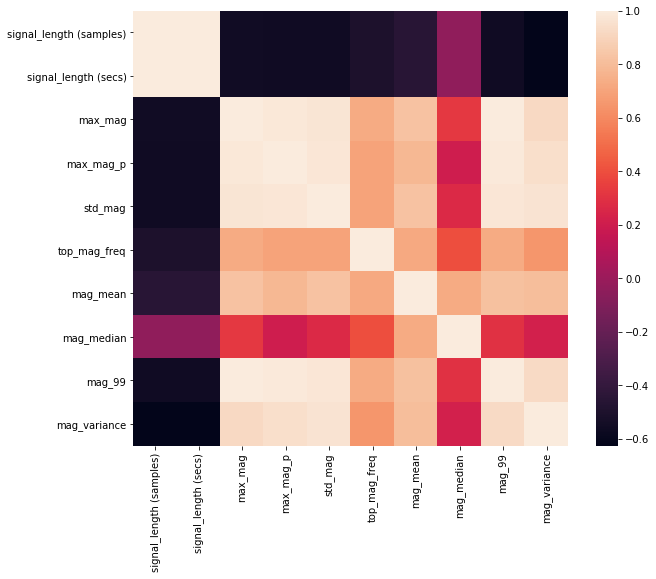

In [67]:
import seaborn as sns # Seaborn is just a prettier plotting library

plt.figure(figsize=(10, 8))
sns.heatmap(corr, square=True);

We can also plot a "prettier" version of the correlation matrix (that also takes advantage of its symmetry by only showing one side).

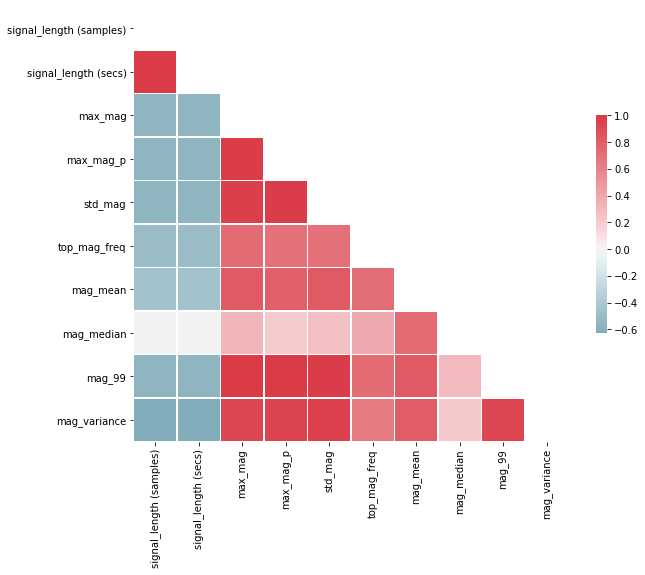

In [68]:
# Plot a "pretty" version of the correlation matrix 
# Based on: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Given that the correlation table is symmetrical, we remove one side 

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

# Classification 

Whew—and to think, we haven't even made it to classification yet!

But it's important to focus on selecting good features because even the most advanced classifiers won't work without good training examples.

Below, we will walk through an entire end-to-end classification example with Scikit-learn using a selected gesture set.

## Feature extraction code

Now that we've explored some features, you can add in some promising features to the method `extract_features_from_trial`, which our classifiers will use below.

This is where you spend quite a bit of time adding, subtracting, and manipulating input features for your model.

In [69]:
def extract_features_from_gesture_set(gesture_set):
    '''
    Extracts features from the gesture set
    '''
    list_of_feature_vectors = []
    column_headers = None
    for gesture_name in gesture_set.get_gesture_names_sorted():
        gesture_trials = gesture_set.map_gestures_to_trials[gesture_name]
        #print(gesture_name, gesture_trials)
        for trial in gesture_trials:
            features, feature_names = extract_features_from_trial(trial)
             
            # add in bookkeeping like gesture name and trial num
            # you shouldn't need to modify this part
            features.append(gesture_set.get_base_path())
            feature_names.append("gesturer")

            features.append(gesture_name)
            feature_names.append("gesture")

            features.append(trial.trial_num)
            feature_names.append("trial_num")
    
            list_of_feature_vectors.append(features)
        
            if column_headers is None:
                column_headers = feature_names
    return (list_of_feature_vectors, column_headers)

def extract_features_from_trial(trial):
    '''Returns a tuple of two lists (a list of features, a list of feature names)'''
    
    # Play around with features to extract and use in your model
    # Brainstorm features, visualize ideas, try them, and iterate
    # This is likely where you will spend most of your time :)
    # This is the "feature engineering" component of working in ML
    features = []
    feature_names = []
    
    # TODO: you may or may not want to keep these features
    # I just added them as examples! :)
    features.append(np.max(trial.accel.mag)) # append feature
    feature_names.append("mag.max()")        # add in corresponding name
    
#     features.append(np.std(trial.accel.mag))
#     feature_names.append("std(mag.max())")
    
    features.append(len(trial.accel.mag))
    feature_names.append("signal_length")
    
    features.append(extract_feature_top_mag_freq2(trial.accel))
    feature_names.append("top_mag_freq")
    
    # TODO:
    # This is where you add in your new features to train the model
    features.append(extract_feature_mag_median(trial.accel))
    feature_names.append("mag_median")
    
#     features.append(extract_feature_mag_mean(trial.accel))
#     feature_names.append("mag_mean")
    
#     features.append(extract_feature_mag_99(trial.accel))
#     feature_names.append("mag_99")
    
#     features.append(extract_feature_mag_variance(trial.accel))
#     feature_names.append("mag_variance")
    
    return (features, feature_names)

## Building an initial classifier

Alright, let's build an initial feature-based, supervised learning classifier for our gesture data. For this example, we will use a [Support Vector Machine (SVM)](https://scikit-learn.org/stable/modules/svm.html), a popular machine learning approach often used in gesture classification. (But other classification models are also possible, which we will show later. Thankfully, Scikit-learn is setup rather beautifully to enable us to swap in and out different classification models and parameters).

### Extract our features

First, let's run our feature extraction code and setup a Pandas DataFrame.

In [70]:
# Extract our features

# Set the selected gesture set. We'll start with my gesture set but you can loop around
# and play with your own
selected_gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, "Alexandra")

(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set)
sorted_gesture_names = sorted(selected_gesture_set.map_gestures_to_trials.keys())

# We'll convert the feature vector and feature names lists into Pandas tables
# which simply makes interacting with Scikit-learn easier
df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)

# We don't want the trial number or gesturer to be an input feature, so remove
trial_indices = df.pop("trial_num") 
gesturer = df.pop('gesturer')
y = df.pop('gesture')

# Scikit-learn documentation consistently refer to the input feature table as X
# and the ground truth labels for this table as either y or y_true. We'll 
# use the same naming conventions
X = df

# Display the feature vector table and ground truth labels
print(f"Selected gesture set: {selected_gesture_set.name}")
display_tables_side_by_side(df, pd.DataFrame(y), n = 8, 
                            df1_caption = "Features", df2_caption = "Ground truth labels")

Selected gesture set: AlexandraGestures


Features mag.max() signal_length top_mag_freq mag_median 
 
 0 
 8300.053012 
 193 
 0.000000 
 7832.567906 
 
 
 1 
 7940.434245 
 85 
 0.000000 
 7805.917755 
 
 
 2 
 8033.736864 
 87 
 0.000000 
 7833.613725 
 
 
 3 
 8169.860709 
 190 
 0.000000 
 7802.498060 
 
 
 4 
 8032.637425 
 136 
 0.000000 
 7810.778185 
 
 
 5 
 47741.817644 
 75 
 4.960000 
 11917.282912 
 
 
 6 
 30352.603051 
 161 
 0.000000 
 8155.590966 
 
 
 7 
 40794.107810 
 148 
 4.351351 
 8070.720420 
 
 Ground truth labels gesture 
 
 0 
 At Rest 
 
 
 1 
 At Rest 
 
 
 2 
 At Rest 
 
 
 3 
 At Rest 
 
 
 4 
 At Rest 
 
 
 5 
 Backhand Tennis 
 
 
 6 
 Backhand Tennis 
 
 
 7 
 Backhand Tennis

### Creating the classifier model

As previously noted, we will use an SVM for this example. As [Wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine) notes, "Given a set of training examples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new examples to one category or the other". More specifically, an SVM constructs a "hyper-plane" that attempts to divide input features along a decision boundary. The samples along this decision boundary are called the "support vectors" since they are "supporting" the limits of the hyper-plane. 

<center>
<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_separating_hyperplane_0011.png" width=500>
    <caption><smaller>This figure shows a binary classification with three samples on the decision boundary (the "support vectors")</smaller></caption>
</center>

For more information on SVMs, I recommend this approachable video by Alice Zhao entitled [Support Vector Machines: A Visual Explanation with Sample Python Code](https://youtu.be/N1vOgolbjSc).

I also suggest that you read through Scikit-learn's [Supervised Learning](https://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html) tutorial.

So, let's do it!

In [71]:
from sklearn import svm

# Create a basic SVM with a linear kernel
# See: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
# Note: this simply instantiates the svm.SVC class and stores it in a var called clf
# it does not actually train and run the SVM (that comes later)
clf = svm.SVC(kernel='linear')

Yes, that's it. Rather anti-climatic, I know. Of course, there are many different types of SVM kernels (`linear`, `poly`) and also parameters to tune like a regularization factor called `C` and many other [things](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) (not to mention other [classifiers](https://scikit-learn.org/stable/supervised_learning.html)). You'll likely want to experiment and read about these parameters.

For now, however, let's just focus on getting the full classification framework setup.

### Setting up the experiment

How should we evaluate our classifier's performance? In the shape-matching assignment, we used k-fold cross validation but there are other approaches. 

In setting up our experiment, we want to ensure:
- That we properly split our data into training and test sets. Often, an easy mistake to make (for novices and experts alike) is to accidentally include some test data into the training set. This will artifically inflate performance. Scikit-learn's experimental frameworks guard against this.
- That we don't necessarily run only a single experiment on one arbitrary split of the data. This may also give us a distorted view of performance.

The most straightforward is called 

#### 80/20 Split

The simplest experimental setup is to divide your data into a training and test set (*e.g.,* 50% for training, 50% for test). A common split is 80% for training and 20% for testing. This is a bit like our previous k-fold approach but only doing one fold (and thus, is not as rigorous).

Scikit-learn has a built-in function for this aptly called [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [72]:
from sklearn.model_selection import train_test_split

# 80/20 split with stratification
# in this case, we have 11 gestures x 5 samples = 55 total
# so, 20% of this is 11 samples. we want to stratify by gesture name so that we get 1 example of each
# gesture in our test set. if we don't have stratify on, we could end up with an imbalanced test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, stratify=y)

print("The training data:")
#display(X_train)
display_tables_side_by_side(X_train, pd.DataFrame(y_train), df1_caption="Input features", df2_caption="Class")

print("The test data:")
display_tables_side_by_side(X_test, pd.DataFrame(y_test), df1_caption="Input features", df2_caption="Class")

The training data:


,mag.max(),signal_length,top_mag_freq,mag_median
23,33381.019757,163,1.693252,6978.201487
31,16916.063845,236,0.779661,7991.426849
21,33634.150264,162,1.703704,7434.120372
30,18919.612681,219,0.840183,7892.493649
10,42396.223228,151,3.655629,8740.687387
43,22887.305128,198,2.787879,10790.118344
13,51839.375305,131,7.022901,10480.158777
33,18676.558141,245,0.751020,7825.962944
14,53421.002611,124,8.161290,10126.259069
44,18335.560204,190,2.421053,10769.428448


The test data:


,mag.max(),signal_length,top_mag_freq,mag_median
27,14136.015846,229,1.606987,8208.374260
24,37861.855845,177,1.559322,7718.122051
3,8169.860709,190,0.000000,7802.498060
51,26322.776753,156,0.000000,7910.293645
5,47741.817644,75,4.960000,11917.282912
36,20818.656249,213,0.863850,7771.883684
19,46185.617848,134,4.119403,8610.783466
11,52300.546842,154,3.584416,9104.856008
47,42401.793170,162,6.246914,17991.011050
40,32360.022744,200,3.220000,12604.735790


#### Basic k-fold cross validation

In the [shape-matching assignment](https://makeabilitylab.github.io/physcomp/signals/gesturerec/shapebased/index.html), you implemented your own k-fold cross validation algorithm. While we didn't emphasize this then, your k-fold implementation was a type of **stratified** k-fold in that your folds guarantteed one sample of each class in each fold.

A more general k-fold implementation is class agnostic: it will split up your data randomly into five folds with no guarantees about class representation.

We can use [`sklearn.model_selection.KFold(n_splits=5, *, shuffle=False, random_state=None)`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) for this, which takes in:
- **n_splits**: Number of folds. Must be at least 2. Defaults to 5.
- **shuffle**: Whether to shuffle the data before splitting into folds.
- **random_state**: Controls how to shuffle the data. If you want to repeat the same random shuffling, pass in an **int** to be used as the random seed.

Let's take a look.

In [73]:
from sklearn.model_selection import KFold

kf_cross_validator = KFold(n_splits=5, shuffle=True)
display_folds(kf_cross_validator, X, y, trial_indices)

,Fold 0,Fold 1,Fold 2,Fold 3,Fold 4
0,At Rest 0,Backhand Tennis 4,Backhand Tennis 0,At Rest 4,At Rest 1
1,At Rest 2,Baseball Throw 1,Backhand Tennis 2,Backhand Tennis 1,At Rest 3
2,Forehand Tennis 2,Baseball Throw 3,Baseball Throw 2,Baseball Throw 0,Backhand Tennis 3
3,Forehand Tennis 4,Forehand Tennis 0,Forehand Tennis 3,Baseball Throw 4,Forehand Tennis 1
4,Jump 3,Midair Clockwise 'O' 2,Jump 1,Midair Clockwise 'O' 1,Jump 0
5,Midair 'S' 0,Midair Counter-clockwise 'O' 2,Midair 'S' 3,Midair Clockwise 'O' 3,Jump 2
6,Midair 'S' 1,Midair Counter-clockwise 'O' 4,Midair Clockwise 'O' 0,Midair Clockwise 'O' 4,Jump 4
7,Midair 'S' 4,Midair Zorro 'Z' 1,Midair Zorro 'Z' 0,Midair Counter-clockwise 'O' 1,Midair 'S' 2
8,Midair Counter-clockwise 'O' 3,Shake 2,Midair Zorro 'Z' 2,Shake 1,Midair Counter-clockwise 'O' 0
9,Midair Zorro 'Z' 4,Shake 4,Midair Zorro 'Z' 3,Underhand Bowling 0,Underhand Bowling 1


But the problem with a basic k-fold cross validation, at least for our purposes, is that we want to ensure that the "correct answer" is *always* in a test fold (and this is relatively easy to accomplish because we have a perfectly balanced dataset of five samples per class). The basic KFold model doesn't do this.

So, what do we do? Enter: stratified k-fold cross validation. This is very similar to what you implemented in your last assignment.

#### Stratified k-fold cross validation

A [stratified k-fold cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) creates folds that preserve the percentange of samples for each class (and again, we have a perfectly balanced dataset, so 20% of each class—or one sample—will go in each fold.)

Fortunately, and quite elegantly, the [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) API is the same as for regular [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold): `sklearn.model_selection.StratifiedKFold(n_splits=5, *, shuffle=False, random_state=None)`.

Let's try it out.

If things work the way they should, then we will have one sample of each class in each fold. Take a careful look at the output table.

In [74]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True)
display_folds(skf, X, y, trial_indices)

,Fold 0,Fold 1,Fold 2,Fold 3,Fold 4
0,At Rest 4,At Rest 0,At Rest 1,At Rest 3,At Rest 2
1,Backhand Tennis 3,Backhand Tennis 1,Backhand Tennis 2,Backhand Tennis 0,Backhand Tennis 4
2,Baseball Throw 2,Baseball Throw 3,Baseball Throw 0,Baseball Throw 4,Baseball Throw 1
3,Forehand Tennis 3,Forehand Tennis 1,Forehand Tennis 2,Forehand Tennis 4,Forehand Tennis 0
4,Jump 2,Jump 0,Jump 1,Jump 3,Jump 4
5,Midair 'S' 1,Midair 'S' 4,Midair 'S' 3,Midair 'S' 2,Midair 'S' 0
6,Midair Clockwise 'O' 2,Midair Clockwise 'O' 4,Midair Clockwise 'O' 0,Midair Clockwise 'O' 1,Midair Clockwise 'O' 3
7,Midair Counter-clockwise 'O' 4,Midair Counter-clockwise 'O' 2,Midair Counter-clockwise 'O' 1,Midair Counter-clockwise 'O' 3,Midair Counter-clockwise 'O' 0
8,Midair Zorro 'Z' 1,Midair Zorro 'Z' 2,Midair Zorro 'Z' 0,Midair Zorro 'Z' 4,Midair Zorro 'Z' 3
9,Shake 4,Shake 0,Shake 1,Shake 3,Shake 2


It worked!

#### Playing with shuffle and random state

It's often best to shuffle our folds randomly to setup our validation experiment; however, to control for reproducibility—for example, to use the same split across multiple executions (say, if you changed a preprocessing algorithm and wanted to evaluate its impact)—Scikit-learn allows you to manipulate how the random split occurs. Most simply, by passing in an `int`, which will be used as the random seed for the split. The same `int` will always produce the same split.

Let's check it out!

In [75]:
# Rerun this cell and you'll get new random splits every time
skf = StratifiedKFold(n_splits=5, shuffle=True)
display_folds(skf, X, y, trial_indices)

,Fold 0,Fold 1,Fold 2,Fold 3,Fold 4
0,At Rest 3,At Rest 2,At Rest 4,At Rest 1,At Rest 0
1,Backhand Tennis 2,Backhand Tennis 4,Backhand Tennis 1,Backhand Tennis 3,Backhand Tennis 0
2,Baseball Throw 2,Baseball Throw 1,Baseball Throw 3,Baseball Throw 0,Baseball Throw 4
3,Forehand Tennis 0,Forehand Tennis 4,Forehand Tennis 3,Forehand Tennis 2,Forehand Tennis 1
4,Jump 0,Jump 4,Jump 2,Jump 1,Jump 3
5,Midair 'S' 2,Midair 'S' 1,Midair 'S' 0,Midair 'S' 4,Midair 'S' 3
6,Midair Clockwise 'O' 4,Midair Clockwise 'O' 2,Midair Clockwise 'O' 3,Midair Clockwise 'O' 0,Midair Clockwise 'O' 1
7,Midair Counter-clockwise 'O' 0,Midair Counter-clockwise 'O' 1,Midair Counter-clockwise 'O' 2,Midair Counter-clockwise 'O' 4,Midair Counter-clockwise 'O' 3
8,Midair Zorro 'Z' 1,Midair Zorro 'Z' 0,Midair Zorro 'Z' 4,Midair Zorro 'Z' 2,Midair Zorro 'Z' 3
9,Shake 4,Shake 1,Shake 0,Shake 2,Shake 3


In [76]:
# Rerun this cell and you'll get the same splits every time
kfold_seed = 3 # setting this seed allows us to control the same random split everytime
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=kfold_seed)
display_folds(skf, X, y, trial_indices)

,Fold 0,Fold 1,Fold 2,Fold 3,Fold 4
0,At Rest 3,At Rest 2,At Rest 4,At Rest 0,At Rest 1
1,Backhand Tennis 4,Backhand Tennis 1,Backhand Tennis 0,Backhand Tennis 2,Backhand Tennis 3
2,Baseball Throw 0,Baseball Throw 2,Baseball Throw 3,Baseball Throw 4,Baseball Throw 1
3,Forehand Tennis 1,Forehand Tennis 3,Forehand Tennis 4,Forehand Tennis 0,Forehand Tennis 2
4,Jump 3,Jump 2,Jump 1,Jump 0,Jump 4
5,Midair 'S' 4,Midair 'S' 2,Midair 'S' 3,Midair 'S' 0,Midair 'S' 1
6,Midair Clockwise 'O' 2,Midair Clockwise 'O' 1,Midair Clockwise 'O' 4,Midair Clockwise 'O' 0,Midair Clockwise 'O' 3
7,Midair Counter-clockwise 'O' 1,Midair Counter-clockwise 'O' 2,Midair Counter-clockwise 'O' 3,Midair Counter-clockwise 'O' 4,Midair Counter-clockwise 'O' 0
8,Midair Zorro 'Z' 1,Midair Zorro 'Z' 4,Midair Zorro 'Z' 2,Midair Zorro 'Z' 0,Midair Zorro 'Z' 3
9,Shake 2,Shake 1,Shake 3,Shake 4,Shake 0


### Running the experiment

Finally, we are ready to run our classification experiment using cross-validation.

#### Using cross_val_score

Let's start with the simplest way to this, using [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html), which takes in (among other things):
- **estimator**: A classifier, which Scikit-learn calls more generally an estimator (because their framework works with regression problems as well as classification problems). Recall that we instantiated an SVM model and stored it in the `clf` variable (the SVM has yet to be trained, that's what this step does).
- **X**: our input features
- **y**: the class labels
- **cv**: the cross validation model, which we previously created as a `StratifiedKFold` and stored it in `skf`

In [77]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X, y, cv=skf)
print("Fold scores:", scores)
print("Overall: {:.2f}%".format(np.mean(scores) * 100))

Fold scores: [0.54545455 0.63636364 0.54545455 0.63636364 0.72727273]
Overall: 61.82%


Not bad, huh? 65.5% accuracy with just a few simple features. And you'll be able to do much better once you add in more thoughtful features.

#### Using cross_validate

Let's use the [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) function instead of `cross_val_score` to produce more detailed performance results like how long each training and testing step took (called `fit_time` and `score_time`, respectively). 

Noticeably, the SVM is much faster to train and test than our shape-based models from before!

In [78]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(clf, X, y, cv=skf, return_train_score=False)
print(cv_results)

{'fit_time': array([0.19556713, 0.24950695, 0.24819112, 0.31249499, 0.07548904]), 'score_time': array([0.00081801, 0.0009799 , 0.00101614, 0.00092983, 0.00095201]), 'test_score': array([0.54545455, 0.63636364, 0.54545455, 0.63636364, 0.72727273])}


Beautify into a Pandas DataFrame table.

In [79]:
display(pd.DataFrame(cv_results))
print(f"Overall average: {np.mean(cv_results['test_score']):.3f} (SD={np.std(cv_results['test_score']):0.3f})")

,fit_time,score_time,test_score
0,0.195567,0.000818,0.545455
1,0.249507,0.000980,0.636364
2,0.248191,0.001016,0.545455
3,0.312495,0.000930,0.636364
4,0.075489,0.000952,0.727273


Overall average: 0.618 (SD=0.068)


#### Using cross_val_predict

Perhaps the most useful experimental validation method, however, is [`cross_val_predict`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html), which returns a prediction array that we can use to compute additional performance statistics.

In [80]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(clf, X, y, cv=skf)
print(y_pred)

['At Rest' 'At Rest' 'At Rest' 'At Rest' 'At Rest' 'Baseball Throw'
 'Underhand Bowling' 'Forehand Tennis' 'Forehand Tennis' 'Forehand Tennis'
 'Backhand Tennis' 'Forehand Tennis' 'Baseball Throw' 'Baseball Throw'
 'Baseball Throw' 'Forehand Tennis' 'Forehand Tennis' 'Forehand Tennis'
 'Backhand Tennis' 'Forehand Tennis' 'Jump' 'Jump' 'Jump' 'Jump' 'Jump'
 "Midair 'S'" "Midair Counter-clockwise 'O'" "Midair 'S'" "Midair 'S'"
 "Midair Counter-clockwise 'O'" "Midair Clockwise 'O'"
 "Midair Clockwise 'O'" "Midair Counter-clockwise 'O'"
 "Midair Clockwise 'O'" "Midair Counter-clockwise 'O'"
 "Midair Counter-clockwise 'O'" "Midair Clockwise 'O'"
 "Midair Clockwise 'O'" "Midair 'S'" "Midair Clockwise 'O'" 'Shake'
 "Midair Zorro 'Z'" "Midair Zorro 'Z'" "Midair Zorro 'Z'" "Midair 'S'"
 'Shake' 'Shake' 'Shake' "Midair Zorro 'Z'" 'Shake' "Midair 'S'"
 'Underhand Bowling' 'Underhand Bowling' 'Forehand Tennis'
 'Underhand Bowling']


With the `y_pred` array, you can now use other metrics like accuracy_score, confusion matrix, *etc.*

In [81]:
from sklearn.metrics import accuracy_score

overall_acc = accuracy_score(y, y_pred)
print(f"{overall_acc * 100:0.2f}%")

61.82%


#### Classification report

With the `y_pred` array, we can build a [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html).

In [82]:
from sklearn.metrics import classification_report

print(classification_report(y, y_pred))

                              precision    recall  f1-score   support

                     At Rest       1.00      1.00      1.00         5
             Backhand Tennis       0.00      0.00      0.00         5
              Baseball Throw       0.75      0.60      0.67         5
             Forehand Tennis       0.44      0.80      0.57         5
                        Jump       1.00      1.00      1.00         5
                  Midair 'S'       0.50      0.60      0.55         5
        Midair Clockwise 'O'       0.50      0.60      0.55         5
Midair Counter-clockwise 'O'       0.20      0.20      0.20         5
            Midair Zorro 'Z'       0.75      0.60      0.67         5
                       Shake       0.80      0.80      0.80         5
           Underhand Bowling       0.75      0.60      0.67         5

                    accuracy                           0.62        55
                   macro avg       0.61      0.62      0.61        55
                we

#### Build a confusion matrix

Now let's build our friendly, helpful confusion matrices!

In [83]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, y_pred, labels=sorted_gesture_names)
print(cm)

[[5 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 3 0 0 0 0 0 0 1]
 [0 1 3 1 0 0 0 0 0 0 0]
 [0 1 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 2 0 0 0]
 [0 0 0 0 0 0 3 2 0 0 0]
 [0 0 0 0 0 1 3 1 0 0 0]
 [0 0 0 0 0 1 0 0 3 1 0]
 [0 0 0 0 0 0 0 0 1 4 0]
 [0 0 0 1 0 1 0 0 0 0 3]]


Beautify the confusion matrix:

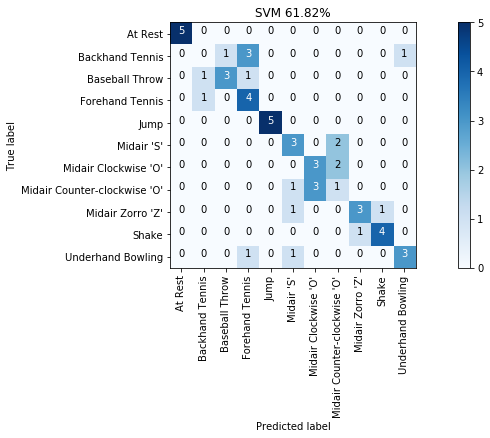

In [84]:
import sklearn.metrics

cm_title = f"SVM {accuracy_score(y, y_pred) * 100:.2f}%"
grvis.plot_confusion_matrix(cm, classes=sorted_gesture_names, title=cm_title)

### Scaling our input features

A final but no less important step—which we skipped over above simply to provide a straightforward example—is that many classifiers (including an SVM) are sensitive to feature scaling. That is, performance varies dramatically if all input features are not normalized.

Fortunately, Scikit-learn has a solution but it does introduce a bit of complexity: namely, we shift from using our core classifier model `clf` to a [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) object, which takes in a list of "steps" and executes them sequentially where steps can include preprocessing, transforming, and eventually classifying an input.

Importantly, Scikit-learn "learns" a feature-scaling model for each feature from the *training* set and applies it to the test set. 

If you're curious about preprocessing data, in general, for machine learning, we suggest Scikit-learn's article on [preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html) and the Wikipedia article on [Feature Scaling](https://en.wikipedia.org/wiki/Feature_scaling).



#### Using a StandardScaler

We'll show how to use one normalization method with Scikit-learn: [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), which standardizes features by removing the mean and scaling to unit variance. As expected, this results in a performance increase.

SCALED RESULTS: 65.45%
                              precision    recall  f1-score   support

                     At Rest       1.00      1.00      1.00         5
             Backhand Tennis       0.00      0.00      0.00         5
              Baseball Throw       0.80      0.80      0.80         5
             Forehand Tennis       0.50      0.80      0.62         5
                        Jump       0.62      1.00      0.77         5
                  Midair 'S'       0.67      0.40      0.50         5
        Midair Clockwise 'O'       0.43      0.60      0.50         5
Midair Counter-clockwise 'O'       0.40      0.40      0.40         5
            Midair Zorro 'Z'       1.00      1.00      1.00         5
                       Shake       1.00      0.80      0.89         5
           Underhand Bowling       0.67      0.40      0.50         5

                    accuracy                           0.65        55
                   macro avg       0.64      0.65      0.63      

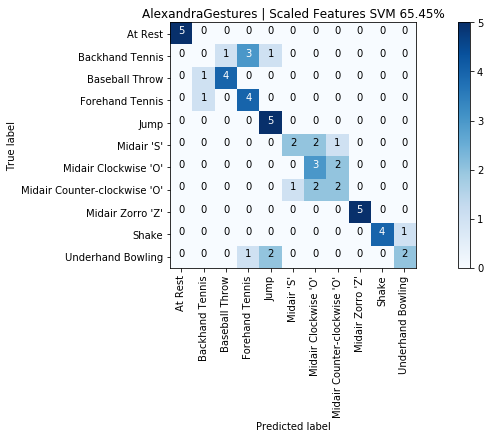

In [85]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create the transform class
scaler = StandardScaler()

# Create the pipeline object. Scikit-learn will execute these objects in sequence
# and use the output from one to the other
pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])

# Now use cross_val_predict with our pipeline object vs. clf
y_pred = cross_val_predict(pipeline, X, y, cv=skf)
print("SCALED RESULTS: {:.2f}%".format(accuracy_score(y, y_pred) * 100))
print(classification_report(y, y_pred, target_names=sorted_gesture_names))

cm = confusion_matrix(y, y_pred, labels=sorted_gesture_names)
graph_title = f"{selected_gesture_set.name} | Scaled Features SVM {accuracy_score(y, y_pred) * 100:.2f}%"
grvis.plot_confusion_matrix(cm, classes=sorted_gesture_names, title=graph_title)

## Full SVM example (redux)

OK, let's do that again but this time in a single cell (so it's easier to see how everything fits together). And let's pick a different gesture set this time as well.

In [86]:
print(f"We have {len(map_gesture_sets)} gesture sets:")
for gesture_set_name, gesture_set in map_gesture_sets.items():
    print(f" {gesture_set_name} with {len(gesture_set.get_all_trials())} trials")

# Feel free to change the selected_gesture_set. It's just a convenient variable
# to explore one gesture set at a time
print(f"The selected gesture set is currently: {selected_gesture_set.name}")

We have 26 gesture sets:
 NickGestures with 55 trials
 NanGestures with 55 trials
 StacyGestures with 55 trials
 AnjaliGestures with 55 trials
 Paf2Gestures with 55 trials
 AGestures with 55 trials
 WolfGestures with 55 trials
 ThweidGestures with 55 trials
 AlexandraGestures with 55 trials
 JaeHGestures with 55 trials
 DustinGestures with 55 trials
 JonGestures with 55 trials
 MattCGestures with 55 trials
 MikaelGestures with 55 trials
 AlexisGestures with 55 trials
 ShaunGestures with 55 trials
 SamuelRGestures with 55 trials
 JustinGestures with 55 trials
 JasonGestures with 55 trials
 NeilGestures with 55 trials
 JuliaBGestures with 55 trials
 BryanGestures with 55 trials
 ClayGestures with 55 trials
 NooseGestures with 55 trials
 EmmaGestures with 55 trials
 BrettGestures with 55 trials
The selected gesture set is currently: AlexandraGestures


Results for AlexandraGestures
Overall SVM accuracy: 56.36%
                              precision    recall  f1-score   support

                     At Rest       1.00      0.60      0.75         5
             Backhand Tennis       0.00      0.00      0.00         5
              Baseball Throw       0.50      0.60      0.55         5
             Forehand Tennis       0.33      0.60      0.43         5
                        Jump       0.62      1.00      0.77         5
                  Midair 'S'       0.67      0.40      0.50         5
        Midair Clockwise 'O'       0.43      0.60      0.50         5
Midair Counter-clockwise 'O'       0.29      0.40      0.33         5
            Midair Zorro 'Z'       1.00      1.00      1.00         5
                       Shake       1.00      0.80      0.89         5
           Underhand Bowling       1.00      0.20      0.33         5

                    accuracy                           0.56        55
                   macro avg 

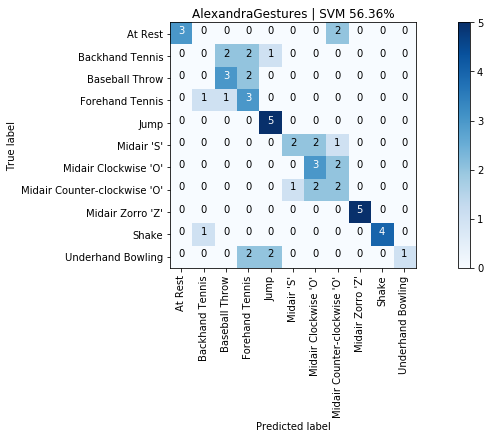

In [91]:
# Grab a gesture set. I'm using "Justin" but feel free to play with any others, including your own (obviously!)
selected_gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, "Alexandra")

(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set)
sorted_gesture_names = sorted(selected_gesture_set.map_gestures_to_trials.keys())

# We'll convert the feature vector and feature names lists into Pandas tables
# which simply makes interacting with Scikit-learn easier
df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)

# We don't want the trial number or gesturer to be an input feature, so remove
trial_indices = df.pop("trial_num") 
gesturer = df.pop('gesturer')
y = df.pop('gesture')

# Scikit-learn documentation consistently refer to the input feature table as X
# and the ground truth labels for this table as either y or y_true. We'll 
# use the same naming conventions
X = df

kfold_seed = 3 # setting this seed allows us to control the same random split everytime
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=kfold_seed)

clf = svm.SVC(kernel='linear', C=0.4)
scaler = StandardScaler()
pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])

print(f"Results for {selected_gesture_set.name}")
y_pred = cross_val_predict(pipeline, X, y, cv=skf)
print("Overall SVM accuracy: {:.2f}%".format(accuracy_score(y, y_pred) * 100))
print(classification_report(y, y_pred, target_names=sorted_gesture_names))

cm = confusion_matrix(y, y_pred, labels=sorted_gesture_names)
graph_title = f"{selected_gesture_set.name} | SVM {accuracy_score(y, y_pred) * 100:.2f}%"
grvis.plot_confusion_matrix(cm, classes=sorted_gesture_names, title=graph_title)

## Experimenting with other classifiers

By now, hopefully, you've realized the breadth and depth of the Scikit-learn library—and again, we've only touched on a small number of possibilities. Before we complete this introduction, we wanted to emphasize one other architectural delight: the various Scikit-learn classifiers have the same basic API and so can be easily swapped and compared with one another (indeed, you can even design and implement your own classifier class if you'd like).

We'll just quickly show two other common classifiers: [k-nearest neighbors (kNN)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) and a [decision tree](https://scikit-learn.org/stable/modules/tree.html).

### kNN classifier
For background on nearest neighbor approaches, read Scikit-learn's [overview](https://scikit-learn.org/stable/modules/neighbors.html).

Results for AlexandraGestures
Overall kNN accuracy: 63.64%
                              precision    recall  f1-score   support

                     At Rest       0.80      0.80      0.80         5
             Backhand Tennis       0.33      0.20      0.25         5
              Baseball Throw       0.60      0.60      0.60         5
             Forehand Tennis       0.43      0.60      0.50         5
                        Jump       0.71      1.00      0.83         5
                  Midair 'S'       0.60      0.60      0.60         5
        Midair Clockwise 'O'       0.50      0.60      0.55         5
Midair Counter-clockwise 'O'       0.40      0.40      0.40         5
            Midair Zorro 'Z'       1.00      1.00      1.00         5
                       Shake       1.00      0.80      0.89         5
           Underhand Bowling       0.67      0.40      0.50         5

                    accuracy                           0.64        55
                   macro avg 

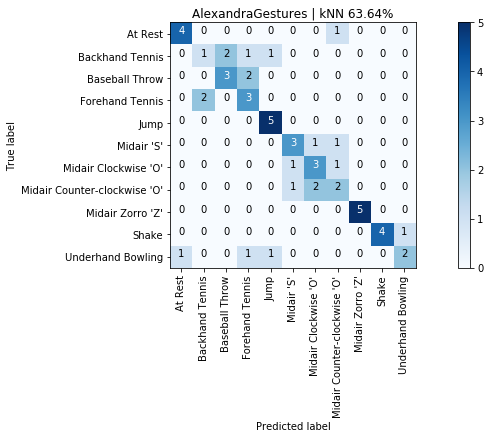

In [92]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=3)
scaler = StandardScaler()
pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])

print(f"Results for {selected_gesture_set.name}")
y_pred = cross_val_predict(pipeline, X, y, cv=skf)
print("Overall kNN accuracy: {:.2f}%".format(accuracy_score(y, y_pred) * 100))
print(classification_report(y, y_pred, target_names=sorted_gesture_names))

cm = confusion_matrix(y, y_pred, labels=sorted_gesture_names)
graph_title = f"{selected_gesture_set.name} | kNN {accuracy_score(y, y_pred) * 100:.2f}%"
grvis.plot_confusion_matrix(cm, classes=sorted_gesture_names, title=graph_title)

### Decision tree classifier
For background on decision trees, read Scikit-learn's [overview](https://scikit-learn.org/stable/modules/tree.html).

Results for JonGestures
Overall kNN accuracy: 67.27%
                              precision    recall  f1-score   support

                     At Rest       1.00      0.80      0.89         5
             Backhand Tennis       0.71      1.00      0.83         5
              Baseball Throw       0.80      0.80      0.80         5
                      Custom       0.80      0.80      0.80         5
             Forehand Tennis       0.67      0.40      0.50         5
                  Midair 'S'       0.67      0.40      0.50         5
        Midair Clockwise 'O'       0.60      0.60      0.60         5
Midair Counter-clockwise 'O'       0.38      0.60      0.46         5
            Midair Zorro 'Z'       1.00      0.60      0.75         5
                       Shake       0.83      1.00      0.91         5
           Underhand Bowling       0.33      0.40      0.36         5

                    accuracy                           0.67        55
                   macro avg       

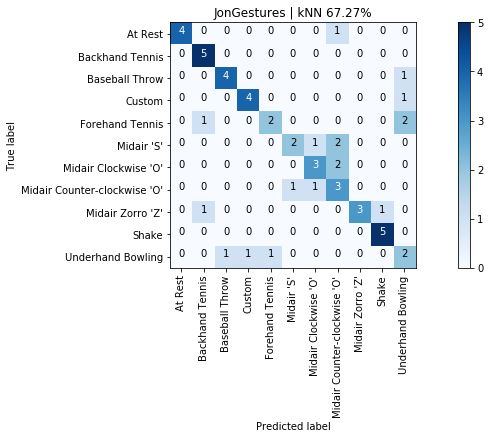

In [89]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)
scaler = StandardScaler()
pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])

print(f"Results for {selected_gesture_set.name}")
y_pred = cross_val_predict(pipeline, X, y, cv=skf)
print("Overall kNN accuracy: {:.2f}%".format(accuracy_score(y, y_pred) * 100))
print(classification_report(y, y_pred, target_names=sorted_gesture_names))

cm = confusion_matrix(y, y_pred, labels=sorted_gesture_names)
graph_title = f"{selected_gesture_set.name} | kNN {accuracy_score(y, y_pred) * 100:.2f}%"
grvis.plot_confusion_matrix(cm, classes=sorted_gesture_names, title=graph_title)

# Cross-user classification

For your assignment, we would like you to build two cross-user models:
- The **first model** is trained on all users (the training set) except for one (the test set). Iterate through all users as test sets and report classification accuracies for each (in graph form) as well as overall accuracies (average accuracy across all users with standard deviation). To be clear, you are not running a standard k-fold cross validation here but instead a leave-one-out validation approach (where you leave one user out from the training set per classification experiment).

- For the **second cross-user model**, train again on *all* users but also four of the five gesture samples (of each gesture) from the target user. To simplify things, you need not run k-fold cross validation. You can simply randomly select four of five gesture samples (once). We expect that classification accuracies should increase here. Is that what happens?

Put your code and performance results below here.

In [90]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
scaler = StandardScaler()
pipeline = Pipeline([('scaler', scaler), ('classifier', loo)])

print(f"Results for {selected_gesture_set.name}")
y_pred = cross_val_predict(pipeline, X, y, cv=skf)
print("Overall LOO accuracy: {:.2f}%".format(accuracy_score(y, y_pred) * 100))
print(classification_report(y, y_pred, target_names=sorted_gesture_names))

cm = confusion_matrix(y, y_pred, labels=sorted_gesture_names)
graph_title = f"{selected_gesture_set.name} | LOO {accuracy_score(y, y_pred) * 100:.2f}%"
grvis.plot_confusion_matrix(cm, classes=sorted_gesture_names, title=graph_title)

TypeError: Last step of Pipeline should implement fit or be the string 'passthrough'. 'LeaveOneOut()' (type <class 'sklearn.model_selection._split.LeaveOneOut'>) doesn't